In [1444]:
import pandas as pd
import numpy as np
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain
import string

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.core.debugger import set_trace

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [1445]:
typeDict = {
    "INFP": ["I","N","F","P"],
    "INFJ": ["I","N","F","J"],
    "INTP": ["I","N","T","P"],
    "INTJ": ["I","N","T","J"],
    "ISFP": ["I","S","F","P"],
    "ISFJ": ["I","S","F","J"],
    "ISTP": ["I","S","T","P"],
    "ISTJ": ["I","S","T","J"],
    "ENFP": ["E","N","F","P"],
    "ENFJ": ["E","N","F","J"],
    "ENTP": ["E","N","T","P"],
    "ENTJ": ["E","N","T","J"],
    "ESFP": ["E","S","F","P"],
    "ESFJ": ["E","S","F","J"],
    "ESTP": ["E","S","T","P"],
    "ESTJ": ["E","S","T","J"],
}

In [1446]:
punctuation = string.punctuation + "“”‘’—–…0123456789\n"
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def cleanPosts(posts):
    
    # Remove punctuation
    posts = posts.translate(str.maketrans('', '', punctuation))
    
    # Tokenize
    words = word_tokenize(posts)
    words = [word.lower() for word in words]
    
    # Remove stop words and gibberish
    words = [word for word in words if (word.isalpha()) and (not word in stop_words)]
    
    # Apply stemming / lemmatization
    
    # Apply lemmatization (if enabled, comment out stemming)
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Apply stemming (if enabled, comment out lemmatization)
    #words = [porter.stem(word) for word in words]
    
    
    # Rejoin words
    review = " ".join(words)
    return review

In [1447]:
numRows = 2000

def getTrainTestLists(filename, getVisualizations):
    
    df = pd.read_csv(filename)
    
    if (getVisualizations):
        createVisualizations(df)
    
    #df = df[0:numRows]
    
    print("Cleaning posts data...")
    df["posts"] = df["posts"].apply(cleanPosts)
    
    train, test = train_test_split(df, test_size=0.2)
    
    return (train["posts"].values, train["type"].values, test["posts"].values, test["type"].values)

In [1448]:
def createVisualizations(df):
    
    df["I/E"] = df['type'].apply(lambda persType: typeDict[persType][0])
    df["S/N"] = df['type'].apply(lambda persType: typeDict[persType][1])
    df["T/F"] = df['type'].apply(lambda persType: typeDict[persType][2])
    df["J/P"] = df['type'].apply(lambda persType: typeDict[persType][3])
    
    sns.set(style="darkgrid")
    
    ax = sns.countplot(x="type", orient="v" ,data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()
    
    ax = sns.countplot(x="I/E", orient="v" ,data=df)
    plt.show()

    ax = sns.countplot(x="S/N", orient="v" ,data=df)
    plt.show()
    
    ax = sns.countplot(x="T/F", orient="v" ,data=df)
    plt.show()
    
    ax = sns.countplot(x="J/P", orient="v" ,data=df)
    plt.show()

In [1449]:
def convertLabelsToAxis(train, test, axisNum):
    
    train_upd = [typeDict[persType][axisNum] for persType in train]
    test_upd = [typeDict[persType][axisNum] for persType in test]
    
    return train_upd, test_upd

In [1450]:
def getTrainMatrix(postsArr):
    vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))
    X = vectorizer.fit_transform(postsArr)
    return X, vectorizer.get_feature_names()

In [1451]:
def getTestMatrix(postsArr, featureArr):
    
    X = []
    
    for posts in postsArr:
        featureDict = dict.fromkeys(featureArr, 0)
        
        for word in posts.split():
            if word in featureDict:
                featureDict[word] += 1
        
        X.append(list(featureDict.values()))
    return X

In [1452]:
# Input: true labels, predicted labels
# Output: accuracy score
def accuEval(y_true, y_predict):
    
    totalCorrect = np.sum(y_true==y_predict)
    totalRows = len(y_predict)
    
    return(totalCorrect/totalRows)

In [1453]:
# Class representation of statistics output for a given model result
class Stats:
    def __init__(self, accu_arr, runtime_arr, name):
        self.mean = np.mean(accu_arr)
        self.std = np.std(accu_arr)
        self.minimum = np.min(accu_arr)
        self.maximum = np.max(accu_arr)
        self.avg_runtime = np.mean(runtime_arr)
        self.name = name

    def __str__(self):
        msg = f'  Statistics for {self.name}:\n'
        msg += f'    Mean       = {self.mean}\n'
        msg += f'    Std. Dev.  = {self.std}\n'
        msg += f'    Minimum    = {self.minimum}\n'
        msg += f'    Maximum    = {self.maximum}\n'
        msg += f'    Avg time   = {self.avg_runtime}\n'
        return msg

In [1454]:
# Running k-fold with a specified number of runs and k value (training/validation accuracy)
def run_kfold(X, y, k):
    
    accu_arr_MNB = np.array([])
    runtimes_MNB = np.array([])
    
    accu_arr_BNB = np.array([])
    runtimes_BNB = np.array([])
    
    accu_arr_LR = np.array([])
    runtimes_LR = np.array([])
    
    accu_arr_LR_PCA = np.array([])
    runtimes_LR_PCA = np.array([])
    
#     accu_arr_LDA = np.array([])
#     runtimes_LDA = np.array([])
    
#     accu_arr_QDA = np.array([])
#     runtimes_QDA = np.array([])
    
    accu_arr_Tree = np.array([])
    runtimes_Tree = np.array([])
    
    accu_arr_RF = np.array([])
    runtimes_RF = np.array([])
    
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, validation_index in kf.split(X):
        
        X_train_split, X_valid_split = X[train_index], X[validation_index]
        y_train_split, y_valid_split = y[train_index], y[validation_index]
        

        start_time = time.time()
        mnb = MultinomialNB()
        mnb.fit(X_train_split, y_train_split)
        predicted_labels = mnb.predict(X_valid_split)
        accu_arr_MNB = np.append(accu_arr_MNB, accuEval(y_valid_split, predicted_labels))
        runtimes_MNB = np.append(runtimes_MNB, (time.time() - start_time))
          
            
        start_time = time.time()
        bnb = BernoulliNB()
        bnb.fit(X_train_split, y_train_split)
        predicted_labels = bnb.predict(X_valid_split)
        accu_arr_BNB = np.append(accu_arr_BNB, accuEval(y_valid_split, predicted_labels))
        runtimes_BNB = np.append(runtimes_BNB, (time.time() - start_time))

        
        start_time = time.time()
        lr = LogisticRegression()
        lr.fit(X_train_split, y_train_split)
        predicted_labels = lr.predict(X_valid_split)
        accu_arr_LR = np.append(accu_arr_LR, accuEval(y_valid_split, predicted_labels))
        runtimes_LR = np.append(runtimes_LR, (time.time() - start_time))
        
        
        start_time = time.time()
        pca = PCA(n_components=50)
        lr2 = LogisticRegression()
        pipe = Pipeline([('pca', pca), ('logistic', lr2)])
        pipe.fit(X_train_split, y_train_split)
        predicted_labels = pipe.predict(X_valid_split)
        accu_arr_LR_PCA = np.append(accu_arr_LR_PCA, accuEval(y_valid_split, predicted_labels))
        runtimes_LR_PCA = np.append(runtimes_LR_PCA, (time.time() - start_time))
        
        
        # Issues with collinear variables... Should probably report this
        # https://stackoverflow.com/questions/47425694/lda-processing-failing-with-variables-are-collinear-error-in-python
#         start_time = time.time()
#         lda = LinearDiscriminantAnalysis()
#         lda.fit(X_train_split, y_train_split)
#         predicted_labels = lda.predict(X_valid_split)
#         accu_arr_LDA = np.append(accu_arr_LDA, accuEval(y_valid_split, predicted_labels))
#         runtimes_LDA = np.append(runtimes_LDA, (time.time() - start_time))
        
#         start_time = time.time()
#         qda = QuadraticDiscriminantAnalysis()
#         qda.fit(X_train_split, y_train_split)
#         predicted_labels = qda.predict(X_valid_split)
#         accu_arr_QDA = np.append(accu_arr_QDA, accuEval(y_valid_split, predicted_labels))
#         runtimes_QDA = np.append(runtimes_QDA, (time.time() - start_time))
        
        
        start_time = time.time()
        decTree = DecisionTreeClassifier(criterion='entropy')
        decTree.fit(X_train_split, y_train_split)
        predicted_labels = decTree.predict(X_valid_split)
        accu_arr_Tree = np.append(accu_arr_Tree, accuEval(y_valid_split, predicted_labels))
        runtimes_Tree = np.append(runtimes_Tree, (time.time() - start_time))
        
        
        start_time = time.time()
        rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
        rf.fit(X_train_split, y_train_split)
        predicted_labels = rf.predict(X_valid_split)
        accu_arr_RF = np.append(accu_arr_RF, accuEval(y_valid_split, predicted_labels))
        runtimes_RF = np.append(runtimes_RF, (time.time() - start_time))
        

    print("\n")
    MNB_Stats = Stats(accu_arr_MNB, runtimes_MNB, 'Multinomial Naive Bayes')
    BNB_Stats = Stats(accu_arr_BNB, runtimes_BNB, 'Bernoulli Naive Bayes')
    LR_Stats = Stats(accu_arr_LR, runtimes_LR, 'Logistic Regression')
    LR_PCA_Stats = Stats(accu_arr_LR_PCA, runtimes_LR_PCA, 'Logistic Regression with PCA')
#     LDA_Stats = Stats(accu_arr_LDA, runtimes_LDA, 'Linear Discriminant Analysis (LDA)')
#     QDA_Stats = Stats(accu_arr_QDA, runtimes_QDA, 'Quadratic Discriminant Analysis (QDA)')
    Tree_Stats = Stats(accu_arr_Tree, runtimes_Tree, 'Decision Tree')
    RF_Stats = Stats(accu_arr_LR, runtimes_LR, 'Random Forest')
    
    print(MNB_Stats)
    print(BNB_Stats)
    print(LR_Stats)
    print(LR_PCA_Stats)
#     print(LDA_Stats)
#     print(QDA_Stats)
    print(Tree_Stats)
    print(RF_Stats)
    print("\n")

In [1455]:
def main():

    fileName = "mbti_1.csv"

    print("Retrieving data from file...")
    getVisualizations = True
    X_train, y_train, X_test, y_test = getTrainTestLists(fileName, getVisualizations)

    print("Getting training matrix and feature array...")
    X_train_matrix, featureArr = getTrainMatrix(X_train)
    X_train_matrix = np.asarray(X_train_matrix.toarray())

    #print(featureArr)

    print("Getting test matrix...")
    X_test_matrix = getTestMatrix(X_test, featureArr)


    pca = PCA(n_components=30)
    pca.fit(X_train_matrix)
    X_transformed = pca.transform(X_train_matrix)
    print("PCA explained variance values:")
    print(pca.explained_variance_.round(2))
    print("\n")

    #     k = 5

    #     print("Running {}-fold cross validation for all 16 personality types ...\n".format(k))
    #     run_kfold(X_train_matrix, y_train, 5)

    #     # 0 - Introversion/Extraversion, 1 - Intuitive/Sensing, 2 - Thinking/Feeling, 3 - Perceiving/Judging

    #     print("Running {}-fold cross validation for introversion/extraversion ...\n".format(k))
    #     y_train_upd, y_test_upd = convertLabelsToAxis(y_train, y_test, 0) 
    #     run_kfold(X_train_matrix, np.asarray(y_train_upd), 5)

    #     print("Running {}-fold cross validation for sensing/intuitive ...\n".format(k))
    #     y_train_upd, y_test_upd = convertLabelsToAxis(y_train, y_test, 1) 
    #     run_kfold(X_train_matrix, np.asarray(y_train_upd), 5)

    #     print("Running {}-fold cross validation for thinking/feeling ...\n".format(k))
    #     y_train_upd, y_test_upd = convertLabelsToAxis(y_train, y_test, 2) 
    #     run_kfold(X_train_matrix, np.asarray(y_train_upd), 5)

    #     print("Running {}-fold cross validation for judging/perceiving ...\n".format(k))
    #     y_train_upd, y_test_upd = convertLabelsToAxis(y_train, y_test, 3) 
    #     run_kfold(X_train_matrix, np.asarray(y_train_upd), 5)



    print("Running final predictions on train and test data for Multinomial Naive Bayes...\n")

    msgList = ["introversion/extraversion...\n", "sensing/intuitive...\n", 
               "thinking/feeling...\n", "judging/perceiving...\n"]

    for i in range(4):
        print(msgList[i])
        y_train_upd, y_test_upd = convertLabelsToAxis(y_train, y_test, i) 
        y_train_upd = np.asarray(y_train_upd)

        mnb = MultinomialNB()
        mnb.fit(X_train_matrix, y_train_upd)

        predicted_labels_train = mnb.predict(X_train_matrix)
        print(f"Training accuracy: {accuEval(y_train_upd, predicted_labels_train)}%")

        predicted_labels_test = mnb.predict(X_test_matrix)
        print(f"Test accuracy: {accuEval(y_test_upd, predicted_labels_test)}%")
        print("\n")


    print("All 16 personalities...\n")

    mnb = MultinomialNB()
    mnb.fit(X_train_matrix, y_train)

    predicted_labels_train = mnb.predict(X_train_matrix)
    print(f"Training accuracy: {accuEval(y_train, predicted_labels_train)}%")

    predicted_labels_test = mnb.predict(X_test_matrix)
    print(f"Test accuracy: {accuEval(y_test, predicted_labels_test)}%")
    print("\n")


    print(classification_report(y_test, predicted_labels_test))
    conf_matrix = pd.crosstab(y_test, predicted_labels_test, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print(conf_matrix)

    conf_matrix_norm = conf_matrix.div(conf_matrix.max(axis=1), axis=0)

    plt.subplots(figsize=(20,20))
    sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues')
    print("Done!")

Retrieving data from file...


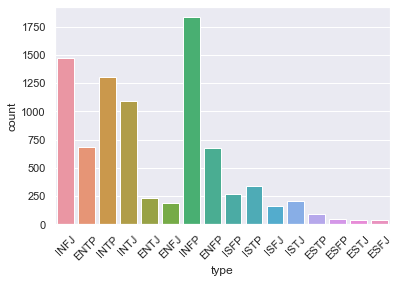

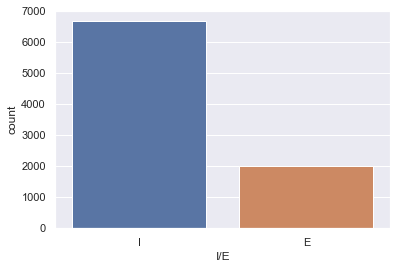

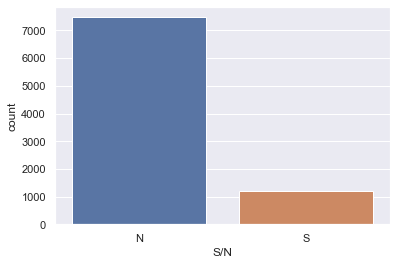

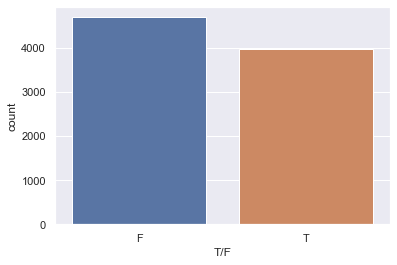

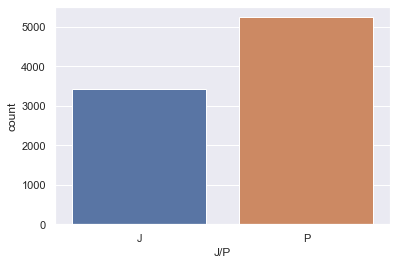

Cleaning posts data...
Getting training matrix and feature array...
Getting test matrix...
PCA explained variance values:
[70.67 23.26 18.44 12.77 12.09  9.82  9.63  8.94  7.98  7.56  7.32  7.08
  6.35  6.16  5.77  5.68  5.28  5.07  5.01  4.73  4.54  4.45  4.3   4.12
  4.05  3.87  3.77  3.72  3.62  3.49]


Running final predictions on train and test data for Multinomial Naive Bayes...

introversion/extraversion...

Training accuracy: 0.84164265129683%
Test accuracy: 0.7855907780979827%


sensing/intuitive...

Training accuracy: 0.9005763688760807%
Test accuracy: 0.8651296829971181%


thinking/feeling...

Training accuracy: 0.850864553314121%
Test accuracy: 0.8097982708933718%


judging/perceiving...

Training accuracy: 0.7906340057636888%
Test accuracy: 0.7198847262247838%


All 16 personalities...

Training accuracy: 0.7855907780979827%
Test accuracy: 0.5435158501440922%


              precision    recall  f1-score   support

        ENFJ       0.53      0.21      0.30        39
    

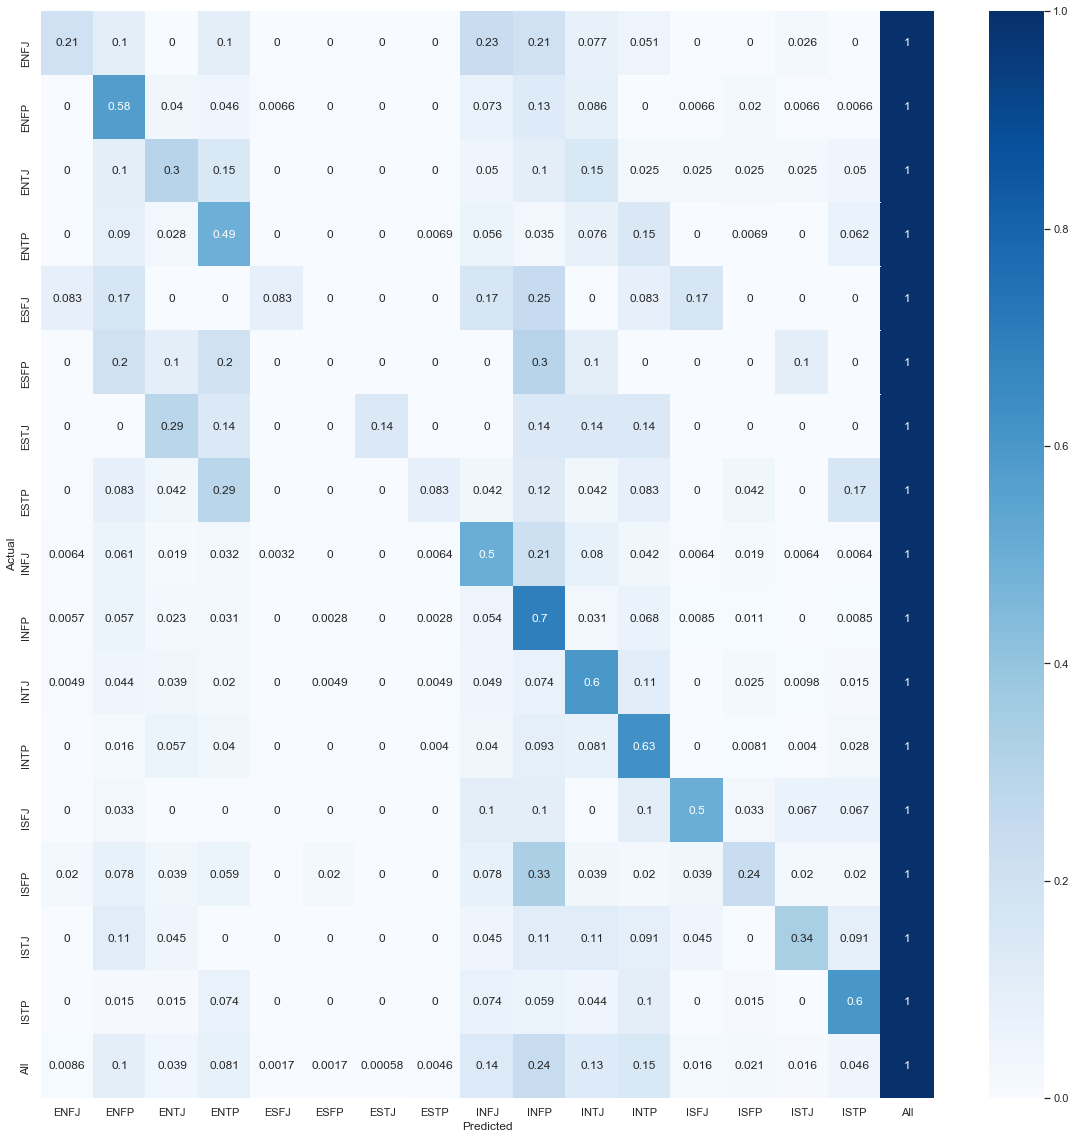

In [1456]:
main()